<a href="https://colab.research.google.com/github/god-data-unimib/DS_LAB_ECONOMICS_FOR_DS/blob/main/work_domenica_alessandro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# DEVE ANDARE SEMPRE QUESTO COMANDO 1 VOLTA
# ! pip install pycaret
# ! pip install shap

In [113]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from pycaret.utils import enable_colab
enable_colab()
from pycaret.classification import *

from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf

from sklearn import metrics
from sklearn.linear_model import LinearRegression, RidgeClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, make_scorer, classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# allow plots to appear directly in the notebook
%matplotlib inline

Colab mode enabled.


# PRE PROCESSING

In [4]:
url = 'https://raw.githubusercontent.com/god-data-unimib/DS_LAB_ECONOMICS_FOR_DS/main/dataset1/telecom_users.csv'
df = pd.read_csv(url)
df = df.drop(columns=['customerID', 'Unnamed: 0'])
df.head()

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0    Male              0     Yes        Yes      72          Yes   
1  Female              0      No         No      44          Yes   
2  Female              1     Yes         No      38          Yes   
3    Male              0      No         No       4          Yes   
4    Male              0      No         No       2          Yes   

  MultipleLines InternetService       OnlineSecurity         OnlineBackup  \
0           Yes              No  No internet service  No internet service   
1            No     Fiber optic                   No                  Yes   
2           Yes     Fiber optic                   No                   No   
3            No             DSL                   No                   No   
4            No             DSL                  Yes                   No   

      DeviceProtection          TechSupport          StreamingTV  \
0  No internet service  No internet service  No internet service   
1                  Yes                   No                  Yes   
2                   No                   No                   No   
3                   No                   No                   No   
4                  Yes                   No                   No   

       StreamingMovies        Contract PaperlessBilling  \
0  No internet service        Two year               No   
1                   No  Month-to-month              Yes   
2                   No  Month-to-month              Yes   
3                  Yes  Month-to-month              Yes   
4                   No  Month-to-month               No   

               PaymentMethod  MonthlyCharges TotalCharges Churn  
0    Credit card (automatic)           24.10      1734.65    No  
1    Credit card (automatic)           88.15       3973.2    No  
2  Bank transfer (automatic)           74.95      2869.85   Yes  
3           Electronic check           55.90        238.5    No  
4           Electronic check           53.45        119.5    No

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5986 entries, 0 to 5985
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5986 non-null   object 
 1   SeniorCitizen     5986 non-null   int64  
 2   Partner           5986 non-null   object 
 3   Dependents        5986 non-null   object 
 4   tenure            5986 non-null   int64  
 5   PhoneService      5986 non-null   object 
 6   MultipleLines     5986 non-null   object 
 7   InternetService   5986 non-null   object 
 8   OnlineSecurity    5986 non-null   object 
 9   OnlineBackup      5986 non-null   object 
 10  DeviceProtection  5986 non-null   object 
 11  TechSupport       5986 non-null   object 
 12  StreamingTV       5986 non-null   object 
 13  StreamingMovies   5986 non-null   object 
 14  Contract          5986 non-null   object 
 15  PaperlessBilling  5986 non-null   object 
 16  PaymentMethod     5986 non-null   object 


MAPPING

In [6]:
df['gender'] = df['gender'].replace({'Male': 0, 'Female':1})
df['Partner'] = df['Partner'].replace({'No': 0, 'Yes':1})
df['Dependents'] = df['Dependents'].replace({'No': 0, 'Yes':1})
df['PhoneService'] = df['PhoneService'].replace({'No': 0, 'Yes':1})
df['MultipleLines'] = df['MultipleLines'].replace({'No': 0, 'Yes':1, 'No phone service' : 3})
df['InternetService'] = df['InternetService'].replace({1: 0, 2: 1, 3: 2})
df['OnlineSecurity'] = df['OnlineSecurity'].replace({'No': 0, 'Yes': 1, 'No internet service': 2})
df['OnlineBackup'] = df['OnlineBackup'].replace({'No': 0, 'Yes': 1, 'No internet service': 2})
df['DeviceProtection'] = df['DeviceProtection'].replace({'No': 0, 'Yes': 1, 'No internet service': 2})
df['TechSupport'] = df['TechSupport'].replace({'No': 0, 'Yes': 1, 'No internet service': 2})
df['StreamingTV'] = df['StreamingTV'].replace({'No': 0, 'Yes': 1, 'No internet service': 2})
df['StreamingMovies'] = df['StreamingMovies'].replace({'No': 0, 'Yes': 1, 'No internet service': 2})
df['PaperlessBilling'] = df['PaperlessBilling'].replace({'No': 0, 'Yes':1})
df['InternetService'] = df['InternetService'].replace({'No': 0, 'Fiber optic': 1, 'DSL': 2})
df['Contract'] = df['Contract'].replace({'Two year': 0, 'Month-to-month': 1, 'One year': 2})
df['PaymentMethod'] = df['PaymentMethod'].replace({'Credit card (automatic)': 0, 'Bank transfer (automatic)': 1, 'Electronic check': 2, 'Mailed check': 3})
df['Churn'] = df['Churn'].replace({'No': 0, 'Yes':1})

In [7]:
# tolti na
df = df.dropna()

In [8]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'],errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5986 entries, 0 to 5985
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            5986 non-null   int64  
 1   SeniorCitizen     5986 non-null   int64  
 2   Partner           5986 non-null   int64  
 3   Dependents        5986 non-null   int64  
 4   tenure            5986 non-null   int64  
 5   PhoneService      5986 non-null   int64  
 6   MultipleLines     5986 non-null   int64  
 7   InternetService   5986 non-null   int64  
 8   OnlineSecurity    5986 non-null   int64  
 9   OnlineBackup      5986 non-null   int64  
 10  DeviceProtection  5986 non-null   int64  
 11  TechSupport       5986 non-null   int64  
 12  StreamingTV       5986 non-null   int64  
 13  StreamingMovies   5986 non-null   int64  
 14  Contract          5986 non-null   int64  
 15  PaperlessBilling  5986 non-null   int64  
 16  PaymentMethod     5986 non-null   int64  


In [9]:
# FILL NAN 

df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].mean())

# BUSINESS APPROACH

FEATURE RANDOM FOREST

primo metodo

In [38]:
feature_names = [f'feature {i}' for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=0)
forest.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [39]:
import time
import numpy as np

start_time = time.time()
importances = forest.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.022 seconds


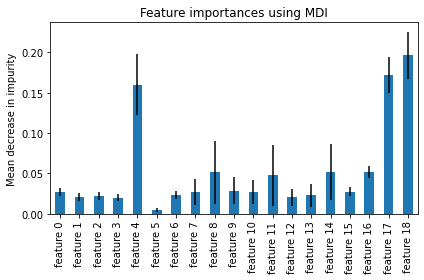

In [40]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

secondo metodo

In [41]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: "
      f"{elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 7.604 seconds


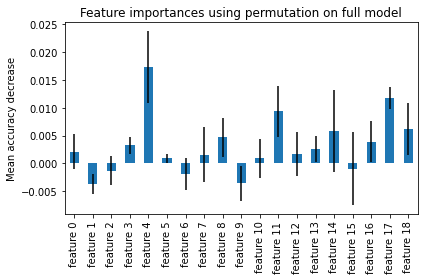

In [42]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

LINEAR REGRESSION

In [10]:
#train, test = train_test_split(df, test_size = 0.2, random_state=42)

In [12]:
target = 'Churn'
X = df.loc[:, df.columns != target]
y = df.loc[:, target]

# Split data
# define models and parameters
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.2)

LOGISTIC REGRESSION PUMPED

In [13]:
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [14]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.798037 using {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
0.797621 (0.014179) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.796227 (0.014321) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.796576 (0.014135) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.797621 (0.014179) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.797064 (0.014918) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.796507 (0.014228) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.797830 (0.014253) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.795950 (0.015019) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.796646 (0.014341) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.797273 (0.015277) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.796158 (0.015733) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.795602 (0.015186) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.797341 (0.016563) with: 

In [18]:
model = LogisticRegression(solver='lbfgs', penalty='l2', C=0.01).fit(X_train, y_train)

In [19]:
model.score(X_train, y_train)

0.7988721804511278

In [20]:
model.score(X_test, y_test)

0.7938230383973289

In [21]:
y_pred = model.predict(X_test)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

#Dummy Classifier Confusion matrix
cm= confusion_matrix(y_test,y_pred)
print('Confusion Matrix : \n' + str(cm))

Accuracy Score : 0.7938230383973289
Precision Score : 0.6147540983606558
Recall Score : 0.49504950495049505
F1 Score : 0.5484460694698355
Confusion Matrix : 
[[801  94]
 [153 150]]


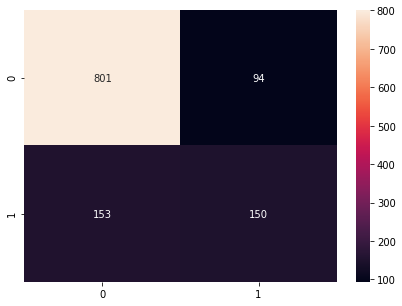

In [22]:
fig, ax = plt.subplots(figsize=(7,5)) 
sns.color_palette("flare", as_cmap=True)
sns.heatmap(cm,annot=True,fmt='d',ax=ax);

RIDGE

In [26]:
# define dataset
# define models and parameters
model = RidgeClassifier()
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# define grid search
grid = dict(alpha=alpha)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.795254 using {'alpha': 0.1}
0.795254 (0.014529) with: {'alpha': 0.1}
0.795254 (0.014529) with: {'alpha': 0.2}
0.795254 (0.014529) with: {'alpha': 0.3}
0.795254 (0.014529) with: {'alpha': 0.4}
0.795254 (0.014529) with: {'alpha': 0.5}
0.795254 (0.014529) with: {'alpha': 0.6}
0.795254 (0.014529) with: {'alpha': 0.7}
0.795254 (0.014529) with: {'alpha': 0.8}
0.795254 (0.014529) with: {'alpha': 0.9}
0.795184 (0.014583) with: {'alpha': 1.0}


In [27]:
model = RidgeClassifier(alpha=1.0).fit(X_train, y_train)
#model.score(X_train, y_train)
model.score(X_test, y_test)

0.7938230383973289

In [28]:
y_pred = model.predict(X_test)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

#Dummy Classifier Confusion matrix
cm= confusion_matrix(y_test,y_pred)
print('Confusion Matrix : \n' + str(cm))

Accuracy Score : 0.7938230383973289
Precision Score : 0.6206896551724138
Recall Score : 0.4752475247524752
F1 Score : 0.5383177570093458
Confusion Matrix : 
[[807  88]
 [159 144]]


In [29]:
# define models and parameters
model = RandomForestClassifier()
n_estimators = [10, 100, 1000]
max_features = ['sqrt', 'log2']
# define grid search
grid = dict(n_estimators=n_estimators,max_features=max_features)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.792190 using {'max_features': 'log2', 'n_estimators': 1000}
0.781193 (0.018618) with: {'max_features': 'sqrt', 'n_estimators': 10}
0.788849 (0.017739) with: {'max_features': 'sqrt', 'n_estimators': 100}
0.792051 (0.017164) with: {'max_features': 'sqrt', 'n_estimators': 1000}
0.780149 (0.018273) with: {'max_features': 'log2', 'n_estimators': 10}
0.790171 (0.016187) with: {'max_features': 'log2', 'n_estimators': 100}
0.792190 (0.017147) with: {'max_features': 'log2', 'n_estimators': 1000}


In [35]:
model=RandomForestClassifier(n_estimators=1000, max_features='log2').fit(X_train,y_train)

y_pred=model.predict(X_test)

In [36]:
y_pred = model.predict(X_test)
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred)))
print('Precision Score : ' + str(precision_score(y_test,y_pred)))
print('Recall Score : ' + str(recall_score(y_test,y_pred)))
print('F1 Score : ' + str(f1_score(y_test,y_pred)))

#Dummy Classifier Confusion matrix
cm= confusion_matrix(y_test,y_pred)
print('Confusion Matrix : \n' + str(cm))

Accuracy Score : 0.7821368948247078
Precision Score : 0.5860655737704918
Recall Score : 0.47194719471947194
F1 Score : 0.5228519195612431
Confusion Matrix : 
[[794 101]
 [160 143]]


In [37]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       895
           1       0.59      0.47      0.52       303

    accuracy                           0.78      1198
   macro avg       0.71      0.68      0.69      1198
weighted avg       0.77      0.78      0.77      1198



LDA

In [90]:

# grid search solver for lda
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [91]:
# define model
model = LinearDiscriminantAnalysis()
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['solver'] = ['svd', 'lsqr', 'eigen']
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Mean Accuracy: 0.794
Config: {'solver': 'svd'}


In [94]:
# define model
model = LinearDiscriminantAnalysis(solver='lsqr')
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid
grid = dict()
grid['shrinkage'] = [0, 1, 0.01]
# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)
# perform the search
results = search.fit(X_train, y_train)
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

Mean Accuracy: 0.794
Config: {'shrinkage': 0}


PYCARET

In [55]:
exp_clf = setup(df,
                target = 'Churn',
                train_size=0.8,
                transformation = True, 
                ignore_low_variance = True,
                remove_multicollinearity = True,
                multicollinearity_threshold = 0.95,
                session_id = 42,
                profile=True)

Summarize dataset:   0%|          | 0/33 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [99]:
# compare all baseline models and select top 5
top5 = compare_models(n_select = 5, sort='Accuracy') 
# tune top 5 base models
tuned_top5 = [tune_model(i, optimize = 'Accuracy') for i in top5]
# ensemble top 5 tuned models
bagged_top5 = [ensemble_model(i) for i in tuned_top5]
# blend top 5 base models 
blender = blend_models(estimator_list = top5, optimize = 'Accuracy') 

Accuracy  AUC  Recall   Prec.      F1   Kappa     MCC
0       0.8038  0.0  0.5000  0.6809  0.5766  0.4527  0.4619
1       0.8142  0.0  0.4766  0.7349  0.5782  0.4659  0.4839
2       0.7912  0.0  0.4609  0.6556  0.5413  0.4114  0.4221
3       0.8225  0.0  0.6094  0.6903  0.6473  0.5294  0.5312
4       0.7829  0.0  0.5504  0.6068  0.5772  0.4316  0.4326
5       0.8038  0.0  0.5116  0.6804  0.5841  0.4590  0.4670
6       0.8246  0.0  0.5116  0.7586  0.6111  0.5034  0.5196
7       0.8372  0.0  0.6047  0.7429  0.6667  0.5604  0.5656
8       0.7720  0.0  0.4609  0.5960  0.5198  0.3735  0.3788
9       0.8180  0.0  0.5938  0.6847  0.6360  0.5155  0.5178
Mean    0.8070  0.0  0.5280  0.6831  0.5938  0.4703  0.4780
SD      0.0193  0.0  0.0550  0.0512  0.0440  0.0543  0.0541

In [100]:
# select best model 
best = automl(optimize = 'Accuracy')

In [109]:
best

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [101]:
best.get_params()

{'n_components': None,
 'priors': None,
 'shrinkage': None,
 'solver': 'svd',
 'store_covariance': False,
 'tol': 0.0001}

In [112]:
evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [108]:
# compare all baseline models and select top 5
top5 = compare_models(n_select = 5, sort='Recall') 
# tune top 5 base models
tuned_top5 = [tune_model(i, optimize = 'Recall') for i in top5]
# ensemble top 5 tuned models
bagged_top5 = [ensemble_model(i, optimize = 'Recall') for i in tuned_top5]
# blend top 5 base models 
blender = blend_models(estimator_list = top5, optimize = 'Recall') 

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7641  0.7889  0.6172  0.5524  0.5830  0.4192  0.4205
1       0.7829  0.8167  0.7109  0.5759  0.6364  0.4840  0.4895
2       0.7724  0.8029  0.7031  0.5590  0.6228  0.4629  0.4692
3       0.7140  0.8100  0.7969  0.4789  0.5982  0.3969  0.4280
4       0.7683  0.8437  0.7597  0.5506  0.6384  0.4742  0.4876
5       0.7975  0.8384  0.7442  0.6000  0.6644  0.5217  0.5279
6       0.7745  0.8343  0.6899  0.5669  0.6224  0.4639  0.4684
7       0.7745  0.8270  0.7364  0.5621  0.6376  0.4782  0.4874
8       0.7720  0.7906  0.5859  0.5725  0.5792  0.4228  0.4228
9       0.7741  0.8320  0.7031  0.5625  0.6250  0.4662  0.4721
Mean    0.7694  0.8185  0.7047  0.5581  0.6207  0.4590  0.4673
SD      0.0204  0.0187  0.0601  0.0296  0.0254  0.0346  0.0327

In [104]:
# select best model 
best2 = automl(optimize = 'Recall')

In [105]:
best2.get_params()

{'priors': None, 'var_smoothing': 1e-09}

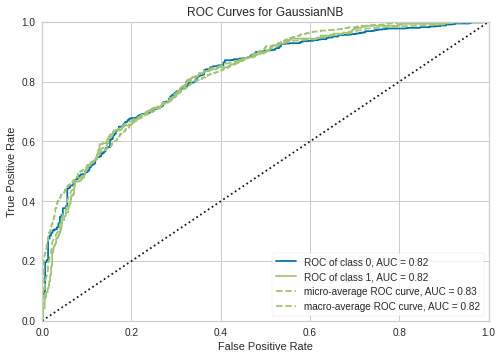

In [106]:
plot_model(best2)

In [111]:
evaluate_model(best2)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [56]:
# best = compare_models()

Model  Accuracy     AUC  Recall   Prec.  \
lda          Linear Discriminant Analysis    0.8076  0.8465  0.5466  0.6765   
lr                    Logistic Regression    0.8051  0.8490  0.5264  0.6776   
ridge                    Ridge Classifier    0.8012  0.0000  0.4890  0.6815   
ada                  Ada Boost Classifier    0.7989  0.8457  0.5404  0.6525   
gbc          Gradient Boosting Classifier    0.7976  0.8475  0.5342  0.6501   
lightgbm  Light Gradient Boosting Machine    0.7888  0.8336  0.5248  0.6282   
svm                   SVM - Linear Kernel    0.7861  0.0000  0.5194  0.6541   
rf               Random Forest Classifier    0.7855  0.8256  0.5007  0.6269   
knn                K Neighbors Classifier    0.7740  0.7879  0.5343  0.5884   
et                 Extra Trees Classifier    0.7732  0.8024  0.4843  0.5947   
nb                            Naive Bayes    0.7467  0.8327  0.7749  0.5198   
dt               Decision Tree Classifier    0.7210  0.6530  0.5024  0.4802   
qda       Quadratic Discriminant Analysis    0.5790  0.6071  0.6681  0.3539   

              F1   Kappa     MCC  TT (Sec)  
lda       0.6026  0.4780  0.4839     0.039  
lr        0.5904  0.4656  0.4732     0.087  
ridge     0.5679  0.4436  0.4547     0.019  
ada       0.5888  0.4577  0.4627     0.243  
gbc       0.5848  0.4531  0.4579     0.597  
lightgbm  0.5706  0.4324  0.4362     0.122  
svm       0.5547  0.4212  0.4391     0.046  
rf        0.5551  0.4165  0.4220     0.756  
knn       0.5585  0.4075  0.4093     0.177  
et        0.5329  0.3855  0.3895     0.717  
nb        0.6214  0.4423  0.4630     0.020  
dt        0.4907  0.2988  0.2992     0.036  
qda       0.4587  0.1681  0.1937     0.024

In [65]:
dt = create_model('rf')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7829  0.8221  0.5234  0.6091  0.5630  0.4197  0.4218
1       0.7641  0.8157  0.4062  0.5843  0.4793  0.3331  0.3423
2       0.7766  0.8224  0.4453  0.6129  0.5158  0.3754  0.3834
3       0.7599  0.8072  0.5391  0.5520  0.5455  0.3824  0.3824
4       0.7912  0.8358  0.5349  0.6330  0.5798  0.4422  0.4450
5       0.7912  0.8496  0.4884  0.6495  0.5575  0.4245  0.4319
6       0.8100  0.8342  0.5349  0.6900  0.6026  0.4804  0.4871
7       0.7787  0.8191  0.5349  0.6000  0.5656  0.4178  0.4190
8       0.7887  0.8101  0.4453  0.6552  0.5302  0.4003  0.4127
9       0.8117  0.8400  0.5547  0.6827  0.6121  0.4895  0.4941
Mean    0.7855  0.8256  0.5007  0.6269  0.5551  0.4165  0.4220
SD      0.0162  0.0130  0.0486  0.0414  0.0378  0.0450  0.0442

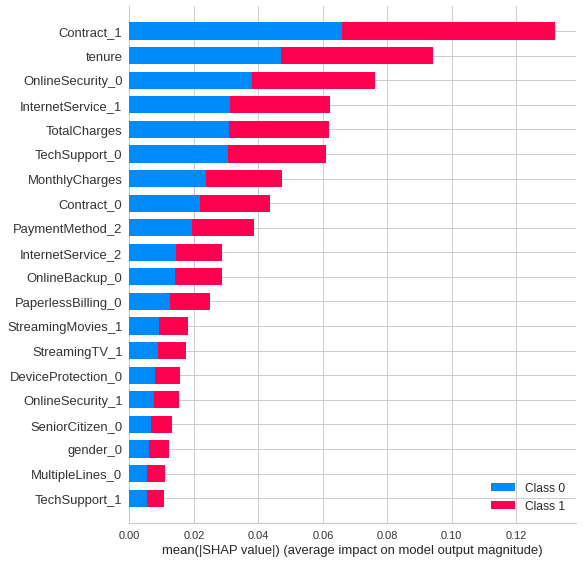

In [66]:
interpret_model(dt)

In [60]:
tuned_rf = tune_model(dt, optimize='Recall')

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7411  0.8361  0.7422  0.5108  0.6051  0.4222  0.4385
1       0.7557  0.8297  0.7578  0.5301  0.6238  0.4512  0.4670
2       0.7474  0.8213  0.7109  0.5200  0.6007  0.4224  0.4334
3       0.7015  0.8266  0.8125  0.4664  0.5926  0.3831  0.4200
4       0.7432  0.8343  0.8295  0.5144  0.6350  0.4533  0.4841
5       0.7787  0.8567  0.7752  0.5650  0.6536  0.4968  0.5103
6       0.7578  0.8378  0.7674  0.5351  0.6306  0.4588  0.4753
7       0.7432  0.8452  0.8140  0.5147  0.6306  0.4487  0.4765
8       0.7343  0.8019  0.7188  0.5027  0.5916  0.4037  0.4179
9       0.7636  0.8377  0.8203  0.5385  0.6502  0.4830  0.5074
Mean    0.7467  0.8327  0.7749  0.5198  0.6214  0.4423  0.4630
SD      0.0194  0.0139  0.0408  0.0245  0.0215  0.0331  0.0322

In [61]:
# calibrate a model
calibrated_dt = calibrate_model(tuned_rf)

Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC
0       0.7620  0.8361  0.6484  0.5461  0.5929  0.4265  0.4296
1       0.7850  0.8297  0.6875  0.5828  0.6308  0.4806  0.4838
2       0.7704  0.8214  0.6406  0.5616  0.5985  0.4387  0.4406
3       0.7495  0.8267  0.7500  0.5217  0.6154  0.4384  0.4542
4       0.7516  0.8344  0.7442  0.5275  0.6174  0.4412  0.4556
5       0.7954  0.8568  0.6899  0.6054  0.6449  0.5021  0.5042
6       0.7745  0.8379  0.6667  0.5695  0.6143  0.4564  0.4592
7       0.7745  0.8452  0.7287  0.5629  0.6351  0.4759  0.4842
8       0.7510  0.8018  0.6250  0.5298  0.5735  0.3994  0.4021
9       0.7887  0.8378  0.7656  0.5799  0.6599  0.5109  0.5212
Mean    0.7703  0.8328  0.6947  0.5587  0.6183  0.4570  0.4635
SD      0.0156  0.0139  0.0474  0.0259  0.0244  0.0332  0.0338

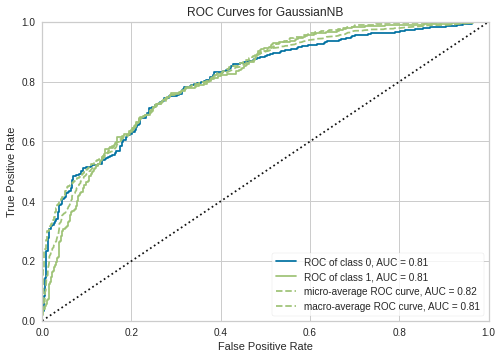

In [44]:
lr = create_model('nb')
plot_model(lr)

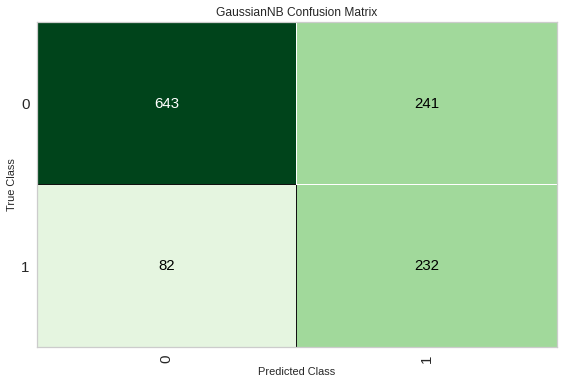

In [45]:
plot_model(plot='confusion_matrix', estimator=lr) 

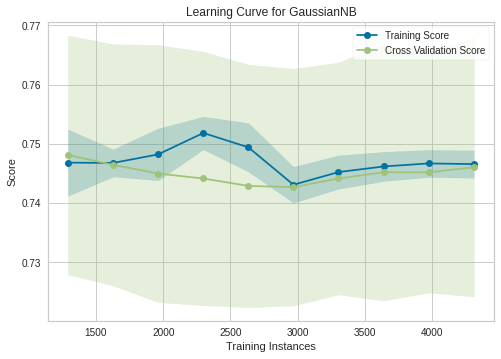

In [46]:
plot_model(plot='learning', estimator=lr) 

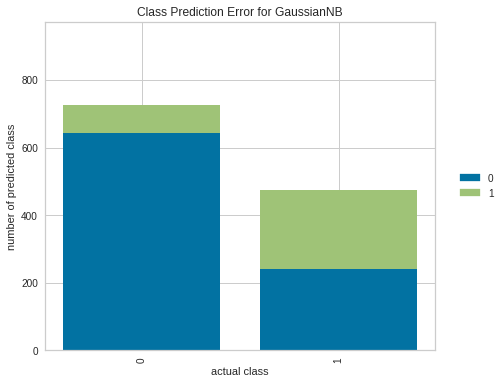

In [47]:
plot_model(plot='error', estimator=lr) 

In [48]:
plot_model(plot='feature', estimator=lr) 

TypeError: ignored

In [ ]:
 plot_model(plot='pr', estimator=lr) 

In [ ]:
plot_model(plot='dimension', estimator=lr) 

# DATA SCIENCE APPROACH

### LOGISTIC REGRESSION

In [ ]:
X_LR = train[['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges']]

y_LR = train['Churn']

In [ ]:
X_LR_test = test[['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges']]
y_LR_test = test['Churn']

GRID-SEARCH

In [ ]:
LR_model = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2', 'elasticnet', 'none'],'C':[0.001,.009,0.01,.09,1,5,10,25, 50, 100]}
grid_clf_acc = GridSearchCV(LR_model, param_grid = grid_values,scoring = 'recall')
grid_clf_acc.fit(X_LR, y_LR)

grid_clf_acc.best_params_

{'C': 0.001, 'penalty': 'none'}

In [ ]:
LR_model = LogisticRegression(solver = 'liblinear', class_weight='balanced', C=25, penalty = 'l1').fit(X_LR, y_LR, sample_weight=None)

In [ ]:
y_pred_LR = LR_model.predict(X_LR_test)

In [ ]:
y_pred_LR

array([1, 1, 0, ..., 1, 0, 1])

In [ ]:
print(classification_report(y_LR_test, y_pred_LR))

              precision    recall  f1-score   support

           0       0.90      0.72      0.80       895
           1       0.47      0.76      0.58       303

    accuracy                           0.73      1198
   macro avg       0.68      0.74      0.69      1198
weighted avg       0.79      0.73      0.74      1198



In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_LR_test,y_pred_LR)))
print('Precision Score : ' + str(precision_score(y_LR_test,y_pred_LR)))
print('Recall Score : ' + str(recall_score(y_LR_test,y_pred_LR)))
print('F1 Score : ' + str(f1_score(y_LR_test,y_pred_LR)))

#Dummy Classifier Confusion matrix
cm= confusion_matrix(y_LR_test,y_pred_LR)
print('Confusion Matrix : \n' + str(cm))

Accuracy Score : 0.7253756260434057
Precision Score : 0.4731404958677686
Recall Score : 0.7557755775577558
F1 Score : 0.5819567979669631
Confusion Matrix : 
[[640 255]
 [ 74 229]]


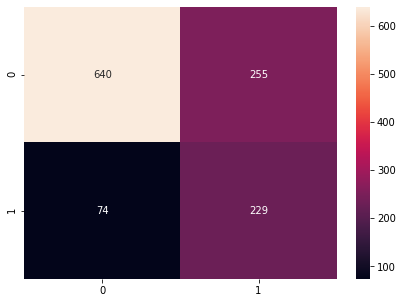

In [ ]:
fig, ax = plt.subplots(figsize=(7,5)) 
sns.color_palette("flare", as_cmap=True)
sns.heatmap(cm,annot=True,fmt='d',ax=ax);

### NAIVE BAYES

In [ ]:
scoring = {'accuracy': make_scorer(accuracy_score), 'recall': make_scorer(recall_score)}

In [ ]:
nb_classifier = GaussianNB()

params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}
gs_NB = GridSearchCV(estimator=nb_classifier, 
                 param_grid=params_NB,  # use any cross validation technique 
                 verbose=1,
                 scoring=scoring,
                 refit='recall') 
gs_NB.fit(X_LR, y_LR)

gs_NB.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.9s finished


{'var_smoothing': 1.519911082952933e-08}

In [ ]:
NB_model = GaussianNB(var_smoothing=1.519911082952933e-08).fit(X_LR, y_LR)

In [ ]:
y_pred_GNB = NB_model.predict(X_LR_test)

In [ ]:
print(classification_report(y_LR_test, y_pred_GNB))

              precision    recall  f1-score   support

           0       0.90      0.65      0.75       895
           1       0.43      0.78      0.55       303

    accuracy                           0.68      1198
   macro avg       0.66      0.71      0.65      1198
weighted avg       0.78      0.68      0.70      1198



In [ ]:
print('Accuracy Score : ' + str(accuracy_score(y_LR_test,y_pred_GNB)))
print('Precision Score : ' + str(precision_score(y_LR_test,y_pred_GNB)))
print('Recall Score : ' + str(recall_score(y_LR_test,y_pred_GNB)))
print('F1 Score : ' + str(f1_score(y_LR_test,y_pred_GNB)))

#Dummy Classifier Confusion matrix
cm= confusion_matrix(y_LR_test,y_pred_GNB)
print('Confusion Matrix : \n' + str(cm))

Accuracy Score : 0.6803005008347245
Precision Score : 0.427536231884058
Recall Score : 0.7788778877887789
F1 Score : 0.552046783625731
Confusion Matrix : 
[[579 316]
 [ 67 236]]


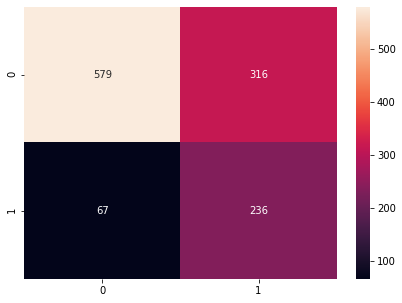

In [ ]:
fig, ax = plt.subplots(figsize=(7,5)) 
sns.color_palette("flare", as_cmap=True)
sns.heatmap(cm,annot=True,fmt='d',ax=ax);